In [1]:
import torch
import torch.nn as nn
import joblib
import anndata as ad
from scipy.stats import spearmanr
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
class RegressionMLP(nn.Module):
    def __init__(self,):
        super().__init__()
        # Example architecture: 1280 -> 512 -> 256 -> 128 -> 1
        self.model = nn.Sequential(
            nn.Linear(1280, 512),
            nn.LeakyReLU(),
            nn.Dropout(0.3),

            nn.Linear(512, 256),
            nn.LeakyReLU(),
            nn.Dropout(0.3),

            nn.Linear(256, 128),
            nn.LeakyReLU(),
            nn.Dropout(0.3),

            nn.Linear(128, 1)
        )
    
    def forward(self, x):
        return self.model(x)

In [3]:
model_baseline_mean_path = '../../data/models/baselines/mean_pear_corr_min_max.joblib'
model_baseline_linreg_path = '../../data/models/baselines/linreg_raw-pear_corr_min_max.joblib'
model_mlp_path = '../../data/models/mlp/pear_corr_min_max_mlp.pt'

anndata_path = '../../data/downstream/meltome.h5ad'

In [4]:
adata = ad.read_h5ad(anndata_path)
adata

AnnData object with n_obs × n_vars = 3009 × 1280
    obs: 'pred_temp', 'real_temp', 'temp_diff'

In [5]:
mlp = torch.load(model_mlp_path, weights_only=False)
mlp.eval()

input_data = torch.from_numpy(adata.X)

with torch.no_grad():
    predictions = mlp(input_data)

adata.obs["mlp_score"] = predictions

In [6]:
baseline_linreg = joblib.load(model_baseline_linreg_path)

input_data = adata.X

predictions = baseline_linreg.predict(input_data)

adata.obs["baseline_linreg_score"] = predictions

In [7]:
baseline_mean = joblib.load(model_baseline_mean_path)

input_data = adata.X

predictions = baseline_mean.predict(input_data)

adata.obs["baseline_mean_score"] = predictions

In [8]:
# Correlation between baseline mean not computable, as their is no variance in predictions

In [9]:
print(adata.obs.mlp_score.corr(adata.obs.temp_diff))
print(adata.obs.baseline_linreg_score.corr(adata.obs.temp_diff))

0.09348302403696893
0.06931042373696485


Spearman correlation: 0.0767 (p-value: 2.510457116496054e-05)


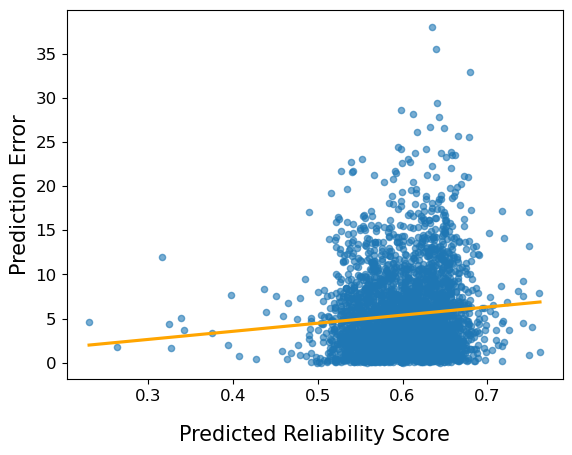

In [10]:
corr, pval = spearmanr(adata.obs["temp_diff"], adata.obs["mlp_score"])

sns.regplot(x="mlp_score", y="temp_diff", data=adata.obs, ci=None, scatter_kws={'alpha': 0.6, 's': 20}, line_kws={'color': 'orange'})
plt.xlabel("Predicted Reliability Score", fontsize=15, labelpad=15)
plt.ylabel("Prediction Error", fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

print(f"Spearman correlation: {corr:.4f} (p-value: {pval})")

<Axes: xlabel='mlp_score', ylabel='Count'>

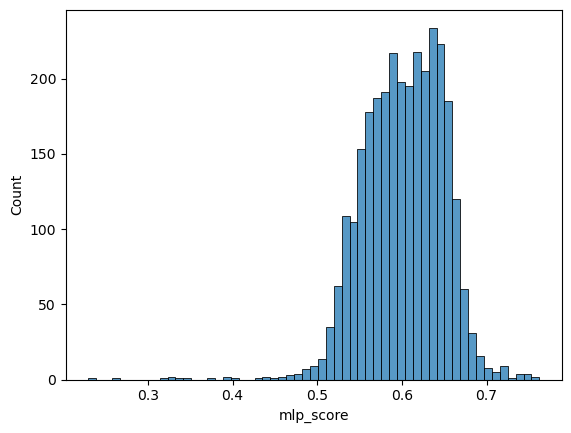

In [11]:
sns.histplot(adata.obs.mlp_score)